#**Preparacion del entorno**

##C**onexion a drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##**Librerias**

In [ ]:
!pip install -U scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 83.5 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sklearn-compat 0.1.3 requires scikit-learn<1.7,>=1.2, but you have scikit-learn 1.7.0 which is incompatible.


In [ ]:
!pip install spacy textstat textblob num2words
!python -m spacy download es_core_news_sm
!pip install -U scikit-learn

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.3/175.3 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.5/163.5 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 939.4/939.4 kB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 55.3 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=1eb8842f5eb6e616e97352f6b51e09c692b5b0d9d77c60a8630451874c67f310
  Stored in directory: /root/.cache/pip/wheels/1a/b0/8c/4b75c4116c31f83c8f9f047231251e13cc74481cca4a78a9ce
Successfully built docopt
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 82.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do thi

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize, TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from textblob import TextBlob

import textstat
import spacy
import re
import os
import warnings


In [ ]:
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)

True

##**Lectura Dataset**

In [ ]:
ruta_dataset = "/content/drive/Shareddrives/Titulo 2/Dataset/dataset.csv"

df_eda = pd.read_csv(ruta_dataset)


#Analisis Exploratorio EDA

## **Sección de las Funciones**

In [ ]:
# Definir estilo de borde para delimitar cada columna
table_styles = [
    {'selector': 'th', 'props': [('font-weight', 'bold'), ('border', '1px solid black')]},
    {'selector': 'td', 'props': [('border', '1px solid black')]}]

In [ ]:
# Mostrar las primeras 5 filas de cada DataFrame
def display_dataframe(df, title):
    print(f"\n{title} (primeras 5 filas):")
    display(df.head(5).style.set_table_styles(table_styles).set_properties(**{'text-align': 'center'}))

In [ ]:
def Clase_Tipo_Dato(df):

    combined_df = pd.DataFrame({
        'Columna': df.columns,
        'Tipo de dato': [df[column].dtypes for column in df.columns],
        'Numero de clases unicas': [df[column].nunique() for column in df.columns]
    })

    # Mostrar el DataFrame estilizado
    display(combined_df.style.set_table_styles(table_styles).set_properties(**{'text-align': 'center'}))


In [ ]:
def limpiar_df(df: pd.DataFrame) -> pd.DataFrame:

    invalid_markers = {"invalid", "no valido", "nan", "n/a"}
    n_inicio = len(df)

    # 1. Eliminar duplicados
    df_clean = df.drop_duplicates()

    # 2. Eliminar filas con cualquier NaN o None
    df_clean = df_clean.dropna(how="any")

    # 3. Eliminar filas con marcadores inválidos en cualquier columna de tipo texto
    def fila_valida(row):
        for val in row:
            if isinstance(val, str) and val.strip().lower() in invalid_markers:
                return False
        return True

    df_clean = df_clean[df_clean.apply(fila_valida, axis=1)]

    n_final = len(df_clean)
    print(f"Se eliminaron {n_inicio - n_final} filas problemáticas (duplicadas, nulas o inválidas).")

    return df_clean

In [ ]:
def graficar_histograma(df: pd.DataFrame, columna: str, bins='auto'):

    datos = df[columna].dropna()
    fig, ax = plt.subplots()

    # Detectar si la columna es numérica
    if pd.api.types.is_numeric_dtype(datos):
        counts, bin_edges = np.histogram(datos, bins=bins)
        centros = (bin_edges[:-1] + bin_edges[1:]) / 2
        width = (bin_edges[1] - bin_edges[0]) * 0.9  # barras más juntas
        ax.bar(centros, counts, width=width, align='center')
        for x, y in zip(centros, counts):
            ax.text(x, y, str(y), ha='center', va='bottom')
        ax.set_xlabel(columna)
        ax.set_ylabel("Frecuencia")
        ax.set_title(f"Histograma de {columna}")
    else:
        # Columnas categóricas: conteo de valores
        conteos = datos.value_counts()
        x = np.arange(len(conteos))
        ax.bar(x, conteos.values)
        ax.set_xticks(x)
        ax.set_xticklabels(conteos.index, rotation=45, ha='right')
        for xi, yi in zip(x, conteos.values):
            ax.text(xi, yi, str(yi), ha='center', va='bottom')
        ax.set_xlabel(columna)
        ax.set_ylabel("Frecuencia")
        ax.set_title(f"Frecuencia de la columna de {columna}")
        plt.tight_layout()

    plt.show()


In [ ]:
def estadisticas_descriptivas_por_categoria(df: pd.DataFrame,
                                            texto_col: str = "Texto",
                                            cat_col: str = "Categoría") -> pd.DataFrame:
    df2 = df.copy()

    df2['Cantidad de tokens'] = df2[texto_col].str.split().str.len()

    # Conteo de caracteres
    df2['Cantidad de caracteres'] = df2[texto_col].str.len()

    # Conteo de oraciones (según signos de puntuación . ! ?)
    df2['Cantidad de oraciones'] = df2[texto_col].str.count(r'[\.!?]')

    # Conteo de signos de exclamación e interrogación
    df2['Cantidad de exclamaciones'] = df2[texto_col].str.count(r'!')
    df2['Cantidad de preguntas']     = df2[texto_col].str.count(r'\?')

    # Conteo de palabras completamente en mayúsculas
    df2['Palabras en mayúsculas'] = df2[texto_col].apply(
    lambda x: sum(1 for w in x.split() if w.isalpha() and w.isupper())
)

# Lista de nombres de métricas en español
    métricas = [
      'Cantidad de tokens',
      'Cantidad de caracteres',
      'Cantidad de oraciones',
      'Cantidad de exclamaciones',
      'Cantidad de preguntas',
      'Palabras en mayúsculas'
  ]

    # Describe global
    print("=== Estadísticas globales ===")
    print(df2[métricas].describe(), "\n")

    # Describe por categoría
    for cat, grupo in df2.groupby(cat_col):
        print(f"=== Estadísticas para Categoría = {cat} ===")
        print(grupo[métricas].describe(), "\n")

    return df2


In [ ]:
def vocabulario_y_ngramas(df: pd.DataFrame,
                          texto_col: str = "Texto",
                          cat_col: str = "Categoria",
                          top_k: int = 20):

    # Descargar stopwords si es necesario
    nltk.download('stopwords', quiet=True)
    from nltk.corpus import stopwords
    spanish_stop = stopwords.words('spanish')

    categorias = df[cat_col].unique()

    for cat in categorias:
        texts = df[df[cat_col] == cat][texto_col].fillna("")

        # Unigramas
        vec_uni = CountVectorizer(ngram_range=(1,1), stop_words=spanish_stop)
        X_uni = vec_uni.fit_transform(texts)
        suma_uni = X_uni.sum(axis=0).A1
        uni_terms = vec_uni.get_feature_names_out()
        df_uni = pd.DataFrame({'term': uni_terms, 'count': suma_uni})
        top_uni = df_uni.sort_values('count', ascending=False).head(top_k)

        fig, ax = plt.subplots()
        ax.bar(range(len(top_uni)), top_uni['count'])
        ax.set_xticks(range(len(top_uni)))
        ax.set_xticklabels(top_uni['term'], rotation=45, ha='right')
        ax.set_title(f"Top {top_k} Unigramas en {cat}")
        ax.set_ylabel("Frecuencia")
        plt.tight_layout()
        plt.show()

        # Bigramas
        vec_bi = CountVectorizer(ngram_range=(2,2), stop_words=spanish_stop)
        X_bi = vec_bi.fit_transform(texts)
        suma_bi = X_bi.sum(axis=0).A1
        bi_terms = vec_bi.get_feature_names_out()
        df_bi = pd.DataFrame({'term': bi_terms, 'count': suma_bi})
        top_bi = df_bi.sort_values('count', ascending=False).head(top_k)

        fig, ax = plt.subplots()
        ax.bar(range(len(top_bi)), top_bi['count'])
        ax.set_xticks(range(len(top_bi)))
        ax.set_xticklabels(top_bi['term'], rotation=45, ha='right')
        ax.set_title(f"Top {top_k} Bigramas en {cat}")
        ax.set_ylabel("Frecuencia")
        plt.tight_layout()
        plt.show()

        # TF-IDF
        tfidf = TfidfVectorizer(ngram_range=(1,1), stop_words=spanish_stop)
        X_tfidf = tfidf.fit_transform(texts)
        scores = X_tfidf.mean(axis=0).A1
        tfidf_terms = tfidf.get_feature_names_out()
        df_tfidf = pd.DataFrame({'term': tfidf_terms, 'score': scores})
        top_tfidf = df_tfidf.sort_values('score', ascending=False).head(top_k)

        print(f"Top {top_k} términos TF-IDF en {cat}:")
        print(top_tfidf.to_string(index=False), "\n")


In [ ]:
# Carga del modelo de SpaCy para español
nlp = spacy.load("es_core_news_sm")

def metricas_semanticas_estilo(df: pd.DataFrame, text_col: str = "Texto") -> pd.DataFrame:
    """
    Añade al DataFrame las siguientes columnas:
      - flesch_reading_ease (puntaje de legibilidad Flesch)
      - smog_index           (índice SMOG)
      - present_verb_ratio   (proporción de verbos en presente)
      - entity_counts        (dict con conteo de cada tipo de entidad)
      - entity_total         (conteo total de entidades)
      - polarity             (polaridad de sentimiento)
      - subjectivity         (subjetividad de sentimiento)
    """
    df2 = df.copy()

    # Legibilidad
    df2['flesch_reading_ease'] = df2[text_col].apply(textstat.flesch_reading_ease)
    df2['smog_index']          = df2[text_col].apply(textstat.smog_index)

    # Proporción de verbos en presente
    def _ratio_present(text):
        doc = nlp(text)
        verbs = [tok for tok in doc if tok.pos_ == 'VERB']
        pres  = [tok for tok in verbs if 'Pres' in tok.morph.get('Tense')]
        return (len(pres)/len(verbs)) if verbs else 0.0
    df2['present_verb_ratio'] = df2[text_col].apply(_ratio_present)

    # Entidades nombradas
    def _count_entities(text):
        doc = nlp(text)
        counts = {}
        for ent in doc.ents:
            counts[ent.label_] = counts.get(ent.label_, 0) + 1
        return counts
    df2['entity_counts'] = df2[text_col].apply(_count_entities)
    df2['entity_total']  = df2['entity_counts'].apply(lambda d: sum(d.values()))

    # Sentimiento
    df2['polarity']     = df2[text_col].apply(lambda t: TextBlob(t).sentiment.polarity)
    df2['subjectivity'] = df2[text_col].apply(lambda t: TextBlob(t).sentiment.subjectivity)

    return df2

In [ ]:
def comparar_metricas_por_categoria(df: pd.DataFrame,
                                           cat_col: str = "Categoría") -> pd.core.frame.DataFrame:
                                           # remove type hint or change it to pandas.core.frame.DataFrame

    # Columnas métricas a comparar
    metricas = [
        'flesch_reading_ease', 'smog_index', 'present_verb_ratio',
        'entity_total', 'polarity', 'subjectivity'
    ]
    # Agregación
    stats = df.groupby(cat_col)[metricas].agg(['mean', 'std', 'median', 'min', 'max'])
    # Aplicar estilos
    return stats.style.set_table_styles(table_styles)

In [ ]:
def matriz_correlacion_texto(df, text_col='Texto', cat_col='Categoria'):
    import nltk
    import matplotlib.pyplot as plt

    # Descargar stopwords si es necesario (opcional si ya no las usas)
    nltk.download('stopwords', quiet=True)

    # Crear copia del DataFrame y calcular métricas numéricas básicas
    df2 = df.copy()
    df2['Cantidad de tokens']        = df2[text_col].str.split().str.len()
    df2['Cantidad de caracteres']    = df2[text_col].str.len()
    df2['Cantidad de oraciones']     = df2[text_col].str.count(r'[\.!?]')
    df2['Cantidad de exclamaciones'] = df2[text_col].str.count('!')
    df2['Cantidad de preguntas']     = df2[text_col].str.count(r'\?')
    df2['Palabras en mayúsculas']    = df2[text_col].apply(
        lambda x: sum(1 for w in x.split() if w.isalpha() and w.isupper())
    )
    df2['Etiqueta de veracidad'] = df2[cat_col].map({'FALSO': 0, 'VERDADERO': 1})

    # Seleccionar columnas numéricas de interés
    numeric_cols = [
        'Cantidad de tokens', 'Cantidad de caracteres', 'Cantidad de oraciones',
        'Cantidad de exclamaciones', 'Cantidad de preguntas',
        'Palabras en mayúsculas', 'Etiqueta de veracidad'
    ]

    # Calcular matriz de correlación
    corr = df2[numeric_cols].corr()

    # Graficar heatmap
    fig, ax = plt.subplots(figsize=(8, 8))
    im = ax.imshow(corr, vmin=-1, vmax=1, cmap='viridis')

    # Ejes y etiquetas
    ax.set_xticks(range(len(corr.columns)))
    ax.set_xticklabels(corr.columns, rotation=45, ha='right')
    ax.set_yticks(range(len(corr.index)))
    ax.set_yticklabels(corr.index)

    # Anotar valores
    for i in range(len(corr)):
        for j in range(len(corr)):
            ax.text(j, i, f"{corr.iloc[i, j]:.2f}", ha='center', va='center', fontsize=7)

    # Barra de color y título
    plt.colorbar(im, ax=ax)
    plt.title('Matriz de Correlación')
    plt.tight_layout()
    plt.show()

##Tipos de datos del dataframe y el resultado de la limpieza del dataset

In [ ]:
Clase_Tipo_Dato(df_eda)

,Columna,Tipo de dato,Numero de clases unicas
0,ID,int64,2075
1,Categoría,object,2
2,Título,object,2075
3,Tópico,object,9
4,Fuente,object,4
5,Texto,object,2075
6,Sub_categoría_tópico,object,19


1. **ID** = Identificador unico de cada fila del df
2. **Categoría** = Categoria binaria para saber si la noticia es fake o true
5. **Título** = Titular de la noticia
3. **Tópico** = Tema de la noticia
4. **Fuente** = Fuente de la noticia
6. **Texto** = Texto de la noticia
7. **Sub_categoría_tópica** = Subcategoría de la categoría Sociedad, en las demás categorías no aplica esta columna.


In [ ]:
df_eda = limpiar_df(df_eda)

Se eliminaron 0 filas problemáticas (duplicadas, nulas o inválidas).


## **Gráfico para ver la cantidad de datos en la columna Categoría de FALSO y VERDADERO**

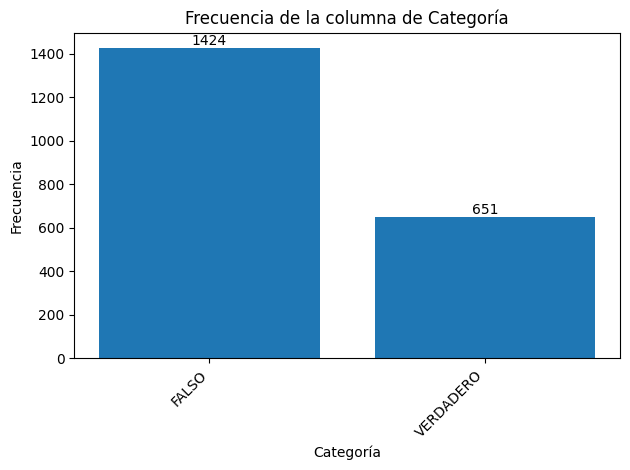

In [ ]:
graficar_histograma(df_eda, "Categoría")


## **Estadísticas del dataset como la cantidad token, caracteres , preguntas y exclamaciones de los textos, más los N-gramas y resultados de las métricas semánticas**

In [ ]:
df_stats = estadisticas_descriptivas_por_categoria(df_eda, "Texto", "Categoría")


=== Estadísticas globales ===
       Cantidad de tokens  Cantidad de caracteres  Cantidad de oraciones  \
count         2075.000000             2075.000000            2075.000000   
mean           103.515181              637.706988               4.867470   
std            181.959932             1127.841170               7.608316   
min              1.000000                4.000000               0.000000   
25%             17.000000              102.000000               0.000000   
50%             32.000000              192.000000               2.000000   
75%             68.000000              413.500000               5.000000   
max            934.000000             5832.000000              45.000000   

       Cantidad de exclamaciones  Cantidad de preguntas  \
count                2075.000000            2075.000000   
mean                    0.240000               0.132530   
std                     1.057754               0.512408   
min                     0.000000               0.

---

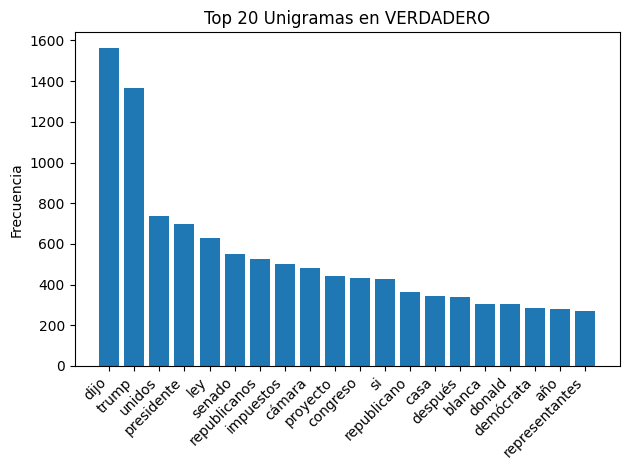

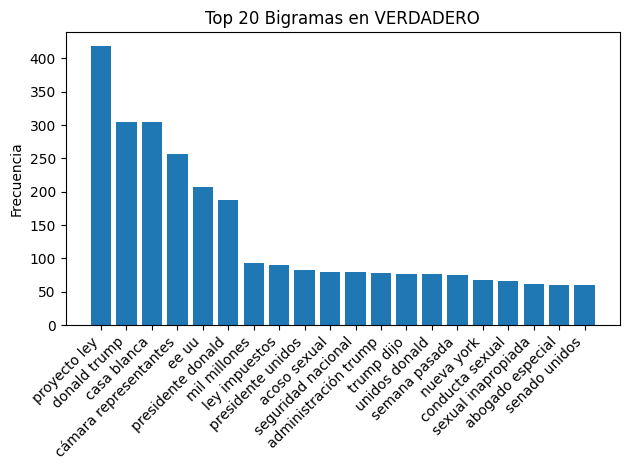

Top 20 términos TF-IDF en VERDADERO:
          term    score
          dijo 0.046942
         trump 0.041184
           ley 0.027150
     impuestos 0.024684
        unidos 0.024502
        senado 0.023986
    presidente 0.023079
        cámara 0.022565
      proyecto 0.022231
  republicanos 0.021085
      congreso 0.017508
            si 0.016861
          casa 0.016042
   republicano 0.015542
        blanca 0.015129
      gobierno 0.014647
representantes 0.014133
     demócrata 0.013591
   legislación 0.013394
        fiscal 0.013371 



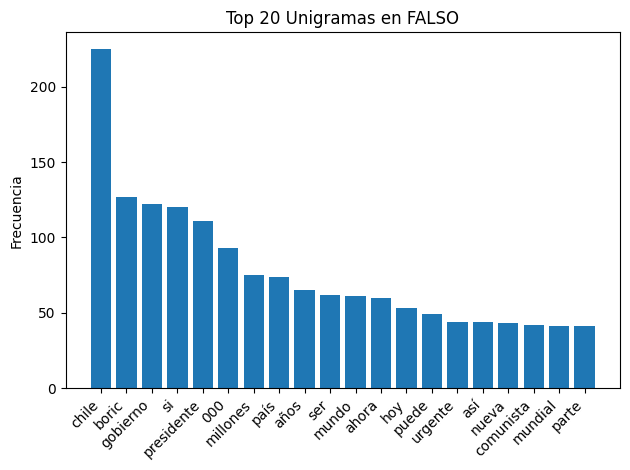

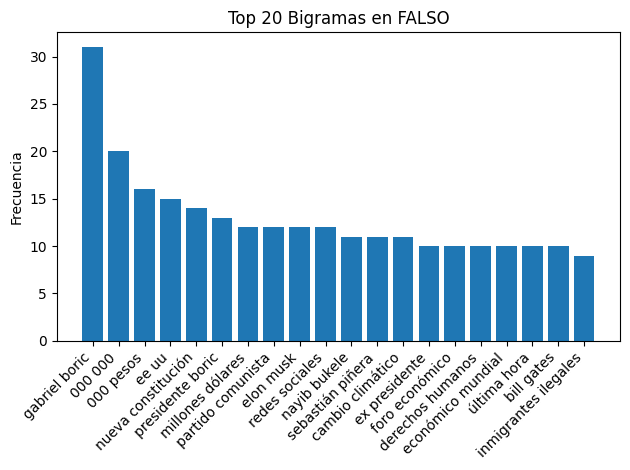

Top 20 términos TF-IDF en FALSO:
      term    score
     chile 0.017842
     boric 0.012920
  gobierno 0.011021
presidente 0.010929
        si 0.009187
  millones 0.007695
       000 0.007500
      país 0.006686
      años 0.006098
     mundo 0.005963
     ahora 0.005950
       ser 0.005622
   urgente 0.005368
     nueva 0.005341
    israel 0.005280
       así 0.005252
       hoy 0.005175
     puede 0.004864
   gabriel 0.004849
     milei 0.004818 



In [ ]:
vocabulario_y_ngramas(df_eda, texto_col="Texto", cat_col="Categoría", top_k=20)

---

In [ ]:
df_metrics = metricas_semanticas_estilo(df_eda, text_col="Texto")
df_stats_sem = comparar_metricas_por_categoria(df_metrics, cat_col="Categoría")
display(df_stats_sem)

In [ ]:
display_dataframe(df_eda, "Primer Vistazo")


Primer Vistazo (primeras 5 filas):


# **Matriz de correlación**

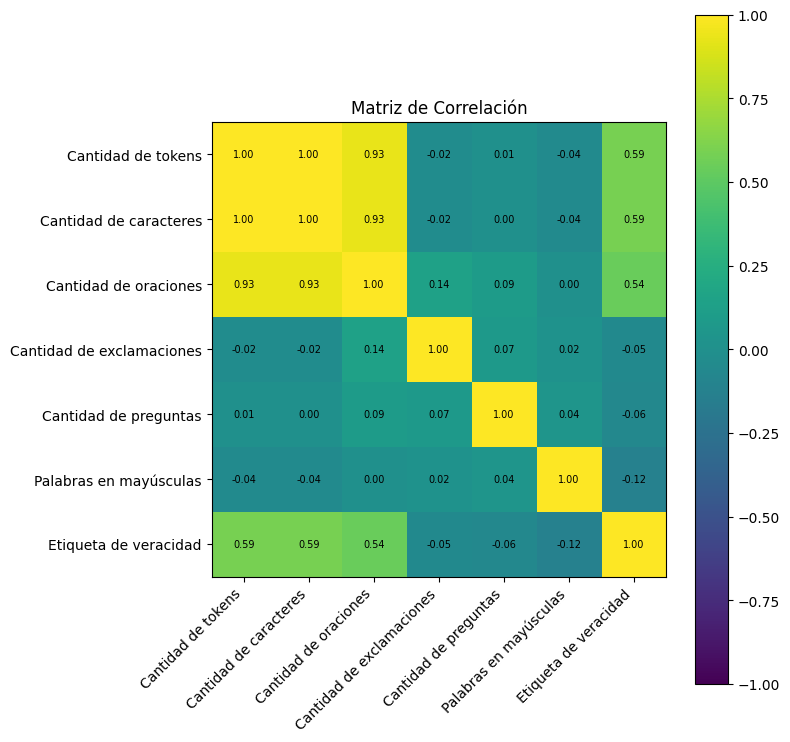

In [ ]:
matriz_correlacion_texto(df_eda, text_col='Texto', cat_col='Categoría')
